# Transfer Learning

Uma das grande barreiras para o uso das redes convolucionais é o grande volume de dados que é necessário para treinar esse tipo de modelo profundo. No entanto, podemos contornar isso fazendo uso de redes pré-treinadas em grandes conjuntos de imagens, tentando assim aproveitar a generalização de características comuns mesmo para dados de contextos diferentes. Essa técnica é chamada de ***Transfer Learning***, não sendo exclusiva para redes convolucionais.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importando dados

Usaremos dados provenientes de uma base de imagens de folhas de plantas com a presença de doenças. O dataset original e uma abordagem de transfer learning para ele pode ser encontrado em https://github.com/abhinavsagar/plant-disease. Aqui trabalharemos com um recorte desse dataset, analisando apenas folhas de árvores de maçã com a presença de algumas patologias.
* Ao trabalhar apenas com esse recorte, temos ainda menos dados, o que torna a tarefa de treinar um modelo profundo bem mais difícil.

* Esse recorte do dataset está disponível na plataforma do curso

In [3]:
path = 'data'

A opção mais clássica para importar os dados é fazer o carregamento de todo o conteúdo diretamente para a memória RAM. Isso funciona bem para volumes de dados que possam ser contidos totalmente na memória da máquina, mas não é uma boa estratégia para altos volumes de dados (muito comuns quando lidando com Big Data)

* Usaremos então um recurso do tensorflow chamado ImageDataGenerator. Esse recurso cria um iterador que gera lotes (*batches*) de imagens a cada iteração, podendo estar apontando para um diretório onde estão nossas amostras (que são imagens nesse exemplo)

* Usaremos o método flow_from_directory para carregar esses dados. Esse método requer que os dados de cada classe estejam em pastas diferentes, sendo que teremos 4 pastas para nossas 4 classes.

* O ImageDataGenerator permite que já façamos algumas transformações nos dados, como fazer a divisão treino-teste e algumas transformações que podem ser aplicadas em imagens, como zoom ou deslocamentos laterais. Mais detalhes sobre essa ferramenta estão disponíveis em https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
# Tamanho das imagens para que sejam usadas como entradas da VGG16
img_size = (224,224)

batch_size = 32

img_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True)
)

train_generator = img_gen.flow_from_directory(
    path + '/Apple_flowers',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)

test_generator = img_gen.flow_from_directory(
    path + '/Apple_flowers',
    target_size=img_size,
    class_mode = 'categorical',
    batch_size=batch_size,
    subset='validation'
)

Found 2537 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


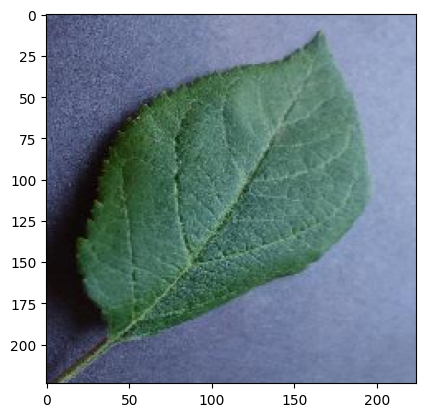

In [7]:
# Exemplo de uma imagem do conjunto que estamos usando
batch_example = train_generator.__next__()
example = batch_example[0][5]

plt.imshow(example)

# Construção do Modelo

Aqui construíremos nosso modelo. Usaremos como base o modelo VGG16 pré-treinado com o conjunto de dados *ImageNet*

* A ideia do Transfer Learning é usar o modelo pré-treinado para extrair algumas características dos nossos dados. Essas extração de características foi previamente aprendida no *ImageNet*

* Para que o modelo seja treinado para o contexto dos nossos dados, excluímos as últimas camadas totalmente conectadas do VGG16, adicionando novas camadas para serem treinadas. Assim, podemos pensar que estamos apenas usando a rede pré-treinada para extrair características e treinando uma rede mlp nova com essas características.

* É importante que façamos com que os pesos dadas camadas extratoras da VGG16 não se alterem durante o treinamento. Apenas as camadas totalmente conectadas que adicionaremos ao modelo é que serão alteradas durante o treinamento

In [8]:
# Carregamos o modelo VGG16 sem as últimas camadas totalmente conectadas (include_top=False)
pre_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Aqui fazemos com que as camadas do modelo pré-treinado não sejam alteradas durante o treino
for layer in pre_model.layers:
  layer.trainable = False

# Criamos então um modelo sequential onde temos o VGG16 seguido das novas camadas conectadas
model = Sequential()

model.add(pre_model)
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

2025-08-11 17:31:29.804762: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
# Checando a estrutura do modelo criado
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,229,192 (65.72 MB)

 Trainable params: 2,514,504 (9.59 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Treinamento do modelo

Finalmente, treinaremos nosso modelo. Para isso podemos passar como dados os geradores que criamos a partir do *ImageDataGenerator*, sendo necessário apenas especificar o número de passos por época de treinamento (*steps_per_epoch*)

In [14]:
model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/30


/home/cordeiro/my-projects/deep_learning_ufv/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - accuracy: 0.4564 - loss: 1.2768 - val_accuracy: 0.7413 - val_loss: 0.5689
Epoch 2/30
 1/79 ━━━━━━━━━━━━━━━━━━━━ 6:43 5s/step - accuracy: 0.5625 - loss: 0.9104

/home/cordeiro/my-projects/deep_learning_ufv/venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5625 - loss: 0.9104 - val_accuracy: 0.7334 - val_loss: 0.5746
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 461s 6s/step - accuracy: 0.6841 - loss: 0.6899 - val_accuracy: 0.8754 - val_loss: 0.3060
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8438 - loss: 0.5134 - val_accuracy: 0.8738 - val_loss: 0.2998
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.8107 - loss: 0.4460 - val_accuracy: 0.8754 - val_loss: 0.2646
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8438 - loss: 0.3304 - val_accuracy: 0.8738 - val_loss: 0.2711
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 456s 6s/step - accuracy: 0.8529 - loss: 0.3492 - val_accuracy: 0.9637 - val_loss: 0.1293
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9688 - loss: 0.1966 - val_accuracy: 0.9574 - val_loss: 0.1277
Epoch 9/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 478s 6s/step - accuracy: 0.9035 - loss: 0.2314 - val_accuracy: 0.9732 - val_loss: 0.0977

In [15]:
# Salva o modelo
model.save('./model_apple_flowers.h5')

# Testando Modelo

A acurácia obtida foi de 97,32%, que parece ser um valor razoável para esse problema. Podemos também avaliar outras medidas, como Precisão, Recall e F1-Score, caso seja preciso um maior detalhamento do desempenho do modelo em cada classe.

Exemplo de imagem do conjunto de teste


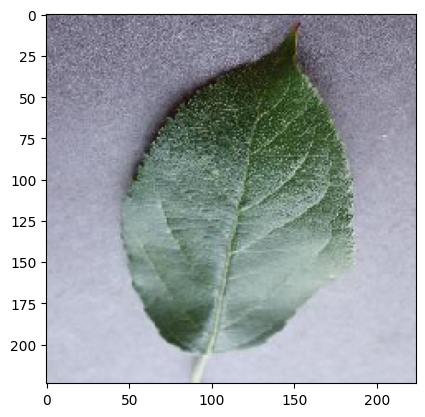

In [16]:
# Lote de 32 imagens do conjunto de teste para classificação
batch_example = test_generator.__next__()
example = batch_example[0][0]

print('Exemplo de imagem do conjunto de teste')
plt.imshow(example);

Faremos agora a classificação do lote de imagens com nosso modelo e identificaremos as classes previstas

In [17]:
np.argmax(model.predict(batch_example[0]), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([3, 2, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 2, 1, 3, 0, 0, 3, 0, 1,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 3])

Agora comparamos com as classes reais dessas imagens do conjunto de teste

In [18]:
np.argmax(batch_example[1], axis=1)

array([3, 2, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 2, 1, 3, 0, 0, 3, 0, 1,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 3])

Cada classe corresponde a uma das seguintes condições da folha presente na imagem

In [19]:
test_generator.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3}